**CRIME DETECTION USING DEEP LEARNING**

**21BCE3988**

In [1]:
# Install the Kaggle Python package silently ("-q" flag) using pip
!pip install -q kaggle

In [2]:
#upload kaggle.json to access Kaggle Datasets
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
# Create a directory named '.kaggle' in the user's home directory
! mkdir ~/.kaggle

# Copy the 'kaggle.json' file to the '.kaggle' directory in the user's home directory
! cp kaggle.json ~/.kaggle/

# Set the permissions of the 'kaggle.json' file to read and write for the owner only
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
#download ucf-crime-dataset
!kaggle datasets download -d odins0n/ucf-crime-dataset

100% 11.0G/11.0G [02:04<00:00, 154MB/s]
100% 11.0G/11.0G [02:04<00:00, 95.3MB/s]


In [5]:
# Unzip the file named 'ucf-crime-dataset.zip'
!unzip ucf-crime-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Train/Vandalism/Vandalism035_x264_230.png  
  inflating: Train/Vandalism/Vandalism035_x264_240.png  
  inflating: Train/Vandalism/Vandalism035_x264_250.png  
  inflating: Train/Vandalism/Vandalism035_x264_260.png  
  inflating: Train/Vandalism/Vandalism035_x264_270.png  
  inflating: Train/Vandalism/Vandalism035_x264_280.png  
  inflating: Train/Vandalism/Vandalism035_x264_290.png  
  inflating: Train/Vandalism/Vandalism035_x264_30.png  
  inflating: Train/Vandalism/Vandalism035_x264_300.png  
  inflating: Train/Vandalism/Vandalism035_x264_310.png  
  inflating: Train/Vandalism/Vandalism035_x264_320.png  
  inflating: Train/Vandalism/Vandalism035_x264_330.png  
  inflating: Train/Vandalism/Vandalism035_x264_340.png  
  inflating: Train/Vandalism/Vandalism035_x264_350.png  
  inflating: Train/Vandalism/Vandalism035_x264_360.png  
  inflating: Train/Vandalism/Vandalism035_x264_370.png  
  inflating: Train/Vandalism/Vandalism

In [6]:
#import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import random
from random import sample
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, AveragePooling2D, Dropout,MaxPooling2D, Conv2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import preprocess_input
from keras.applications import ResNet50
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
from tensorflow.keras.utils import load_img
from collections import Counter
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD


# Data Collection and Preprocessing

In [7]:
# path to the directory containing training images
train_path = '/content/Train'

#path to the directory containing test images
test_path = '/content/Test'


In [8]:
#ImageDataGenerator for augmenting and preprocessing training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')  # Strategy for filling in newly created pixels during transformations


#ImageDataGenerator for preprocessing test images
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [9]:
# Generating a training data generator using train_datagen to flow data from the directory train_path

train_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

# Resizing images to a target size of (64, 64), with a batch size of 32, and categorical class mode

Found 1266345 images belonging to 14 classes.


In [10]:
# Generating a test data generator using test_datagen to flow data from the directory test_path
test_set = test_datagen.flow_from_directory(test_path,
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')


# Resizing images to a target size of (64, 64), with a batch size of 32, and categorical class mode

Found 111308 images belonging to 14 classes.


In [ ]:
# Retrieve the class names from the training set's class indices and convert them to a list
class_names = list(train_set.class_indices.keys())

# Convert the list of class names to a numpy array
class_names = np.array(class_names)
class_names

{'Abuse': 19076, 'Arrest': 26397, 'Arson': 24421, 'Assault': 10360, 'Burglary': 39504, 'Explosion': 18753, 'Fighting': 24684, 'NormalVideos': 947768, 'RoadAccidents': 23486, 'Robbery': 41493, 'Shooting': 7140, 'Shoplifting': 24835, 'Stealing': 44802, 'Vandalism': 13626}


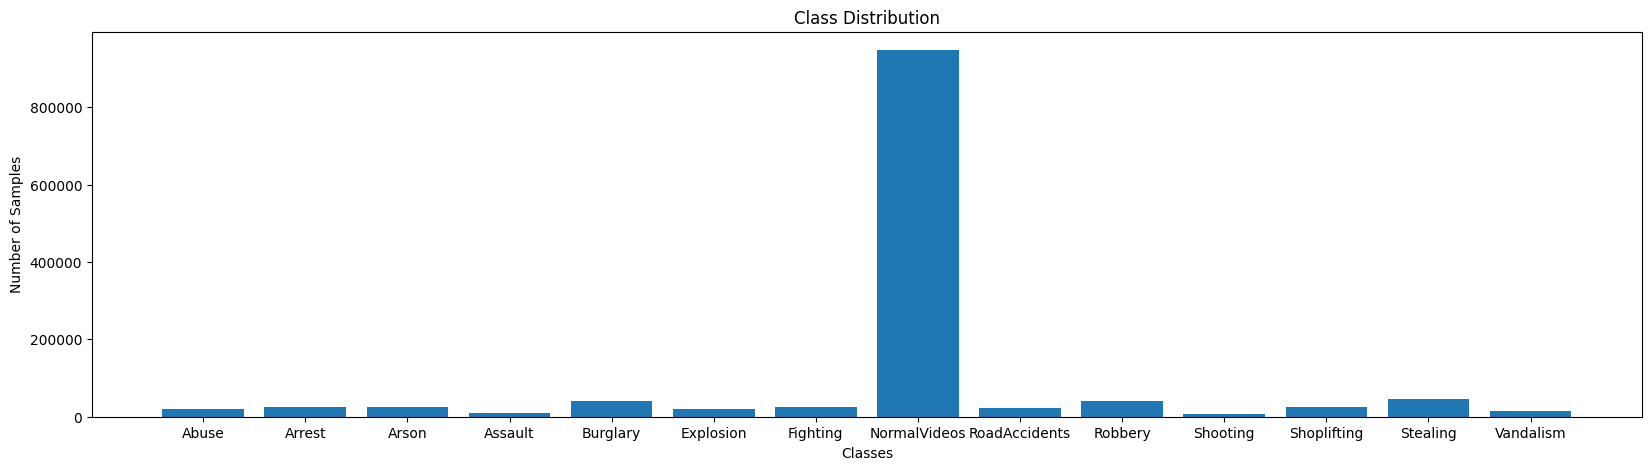

In [12]:
#Visualisation

dataset_path = '/content/Train/'
num_samples=14

# Get the list of class folders (i.e., class names) in the dataset directory
class_folders = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]

# Count the number of samples in each class
class_counts = Counter()
for classes in class_names:
    class_path = os.path.join(dataset_path, classes)
    class_counts[classes] = len(os.listdir(class_path))

# Extract the class names and counts from the Counter object
classes, counts = zip(*class_counts.items())

# Create a dictionary to store class names and their corresponding counts
dcount = dict()
i=0
for crimes in classes:
  dcount[crimes] = counts[i]
  i=i+1

# Print the dictionary containing class names and their counts
print(dcount)
plt.figure(figsize=(20,5))  # Set the figsize here
plt.bar(classes, counts)
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()

Model selection: **MobileNetV2** ,It represents a specific CNN architecture that has been optimized for mobile and embedded applications, making it a popular choice for tasks where real-time inference is required.

# Model Building

In [13]:
from keras.applications.mobilenet_v2 import MobileNetV2

In [14]:
mobilenet_v2 = MobileNetV2(
    input_shape=(64, 64, 3),
    alpha=1.0,
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    pooling=None,
    classes=14,
    classifier_activation='softmax'
)


for layer in mobilenet_v2.layers:
    layer.trainable = False

optimizer = SGD(learning_rate=0.001)

model = Sequential()
model.add(mobilenet_v2)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dense(len(class_names), activation='softmax'))

# Display model summary
model.summary()

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   
 tional)                                                         
                                                                 
 module_wrapper (ModuleWrap  (None, 5120)              0         
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 256)               1310976   
 apper)                                                          
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                           

#Training the model


In [15]:
#Checkpoint used to save the best performances only
checkpoint = ModelCheckpoint(
    filepath='crime.h5',
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
    verbose=1)

from keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_schedule = LearningRateScheduler(scheduler)


In [16]:
#training the model (taking a lotttt of time, but it works)
callbacks = [checkpoint]
epochs=10

#Manually setting the priority of 'NormalVideos' (majority) class
#to balance the dataset
class_weight = {0: 1,
                1: 1,
                2: 1,
                3: 1,
                4: 1,
                5: 1,
                6: 1,
                7: 0.7,
                8: 1,
                9: 1,
                10: 1,
                11: 1,
                12: 1,
                13: 1,}

model_history = model.fit(
  train_set,
  validation_data=test_set,
  epochs=epochs,
  steps_per_epoch = 100,
  callbacks=callbacks,
  # class_weight = class_weight
)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 1.3503 - accuracy: 0.7097
Epoch 1: val_loss improved from inf to 2.58604, saving model to crime.h5
100/100 [==============================] - 344s 3s/step - loss: 1.3503 - accuracy: 0.7097 - val_loss: 2.5860 - val_accuracy: 0.5172
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 1.2624 - accuracy: 0.7222
Epoch 2: val_loss did not improve from 2.58604
100/100 [==============================] - 241s 2s/step - loss: 1.2624 - accuracy: 0.7222 - val_loss: 2.6927 - val_accuracy: 0.4405
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 1.1812 - accuracy: 0.7300
Epoch 3: val_loss improved from 2.58604 to 2.40009, saving model to crime.h5
100/100 [==============================] - 240s 2s/step - loss: 1.1812 - accuracy: 0.7300 - val_loss: 2.4001 - val_accuracy: 0.5697
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 1.1791 - accuracy: 0.7347
Epoch 4: val_loss impro

#Testing the model


In [17]:
from keras.models import load_model

mobilenet_v2 = MobileNetV2(
    input_shape=(64, 64, 3),
    alpha=1.0,
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    pooling=None,
    classes=14,
    classifier_activation='softmax'
)


for layer in mobilenet_v2.layers:
    layer.trainable = False

optimizer = Adam(learning_rate=0.001)

model_predict = Sequential()
model_predict.add(mobilenet_v2)
model_predict.add(Flatten())
model_predict.add(Dense(256, activation='relu'))
model_predict.add(BatchNormalization())
model_predict.add(Dropout(0.2))
model_predict.add(Dense(512, activation='relu'))
model_predict.add(BatchNormalization())
model_predict.add(Dropout(0.2))
model_predict.add(Dense(1024, activation='relu'))
model_predict.add(Dense(len(class_names), activation='softmax'))
model_predict.load_weights('crime.h5')

In [18]:
#Running the model on a single image
from keras.utils import load_img
img = image.load_img('/content/Test/NormalVideos/Normal_Videos_003_x264_2200.png',target_size=(64,64))
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
prediction = np.argmax(model_predict.predict(x))
class_names[prediction]

1/1 [==============================] - 2s 2s/step


'NormalVideos'

In [19]:
#Running the model on Test_set
predictions = model_predict.predict(test_set)
predicted_labels = np.argmax(predictions, axis=1)

3479/3479 [==============================] - 267s 76ms/step


#Evaluating the model


In [20]:
true_labels = test_set.classes

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

precision = precision_score(true_labels, np.argmax(predictions, axis=1), average='weighted')
recall = recall_score(true_labels, np.argmax(predictions, axis=1), average='weighted')
f1 = f1_score(true_labels, np.argmax(predictions, axis=1), average='weighted')

print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1-score: {f1 * 100:.2f}%')

# Print classification report
print('Classification Report:')
print(classification_report(true_labels, np.argmax(predictions, axis=1)))

# Print confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(true_labels, np.argmax(predictions, axis=1)))

Accuracy: 54.16%
Precision: 36.77%
Recall: 54.16%
F1-score: 42.07%
Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       297
           1       0.00      0.00      0.00      3365
           2       0.02      0.01      0.02      2793
           3       0.04      0.00      0.00      2657
           4       0.00      0.00      0.00      7657
           5       0.08      0.01      0.02      6510
           6       0.00      0.00      0.00      1231
           7       0.58      0.92      0.72     64952
           8       0.02      0.00      0.00      2663
           9       0.00      0.00      0.00       835
          10       0.08      0.00      0.01      7630
          11       0.21      0.00      0.00      7623
          12       0.02      0.05      0.03      1984
          13       0.00      0.00      0.00      1111

    accuracy                           0.54    111308
   macro avg       0.08      0.07      0.06    111308
weighted avg       0.37      0.54      0.42    111308

Confusion Matrix:
[[    0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
